In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Literal
from pydantic import BaseModel,Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

/home/bip/archeion/langgraph-tutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
gemini_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite", temperature=0, api_key = os.getenv("GOOGLE_API_KEY"))

In [7]:
groq_model = ChatGroq(model = 'openai/gpt-oss-20b', api_key = os.getenv("GROQ"))

In [9]:
groq_model.invoke("what is shanghai famous for?").content

'Shanghai is famous for a mix of modern grandeur and rich cultural heritage. Here are the highlights:\n\n| Category | What makes Shanghai famous |\n|----------|---------------------------|\n| **Skylines & Architecture** | The futuristic Pudong skyline – Oriental Pearl Tower, Shanghai Tower, Jin Mao Tower – alongside historic colonial streets on the Bund. |\n| **Economic Powerhouse** | One of China’s top financial hubs, home to the Shanghai Stock Exchange, global banks, and multinational corporations. |\n| **Culinary Scene** | A food paradise: xiaolongbao (soup dumplings), shengjianbao (pan‑fried pork buns), seafood, and a booming fusion of local and international cuisines. |\n| **Culture & Arts** | The Shanghai Museum, Shanghai Opera House, and a vibrant contemporary art scene. The city is also a center for film, music, and fashion. |\n| **Transportation Hub** | The world’s busiest passenger airport (Shanghai Pudong), extensive metro, and the historic Shanghai Metro Line 1. |\n| **Shop

# class for structured output to the llm

In [10]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description = 'Sentiment of the review')

class DiagnosisSchema(BaseModel):
    issue_type: Literal['UX', 'Performance', 'Bug', 'Other'] = Field(description = 'Type of issue in the review')
    tone: Literal['angry', 'frustrated', 'disappointed', 'calm'] = Field(description = 'The emotions expressed in the review')
    urgency: Literal['low', 'medium', 'high'] = Field(description = 'How urgent or critical the issue is')
    


In [11]:
structured_model = groq_model.with_structured_output(SentimentSchema)

In [12]:
structured_model2 = groq_model.with_structured_output(DiagnosisSchema)

# State

In [13]:
class SentimentState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

# Nodes

In [15]:
def analyze_sentiment(state: SentimentState):
    prompt = f"For the following review, find out the sentiment \n {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment

    return {
        'sentiment': sentiment
    }

def positive_response(state: SentimentState):
    prompt = f"""Write a warm thank-you message for the following review \n\n "{state['review']}" \n Also, kindy ask the user to leave feedback on our website."""
    response = groq_model.invoke(prompt).content
    return{
        'response': response
    }
    
def run_diagnosis(state: SentimentState):
    prompt = f"""
        Diagnose the negative review: \n\n {state['review']}
        Return the issue type, tone, and urgency of the review.
    """
    response = structured_model2.invoke(prompt)
    return {
        'diagnosis': response.model_dump()
    }

def negative_response(state: SentimentState):
    diagnosis = state['diagnosis']
    prompt = f"""
        You are a support assistant. The user had a '{diagnosis['issue_type']}' issue and sounded '{diagnosis['tone']}' and marked urgency as '{diagnosis['urgency']}'.
        Write an empathetic, helpful resolution message
    """
    response = groq_model(prompt).content
    return{
        'response': response
    }

# Conditional Edge

In [16]:
def check_sentiment(state: SentimentState) -> Literal['positive_response', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'


# Graph

In [17]:
graph = StateGraph(SentimentState)

# nodes
graph.add_node('analyze_sentiment', analyze_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)


# edges
graph.add_edge(START, 'analyze_sentiment')
graph.add_conditional_edges('analyze_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

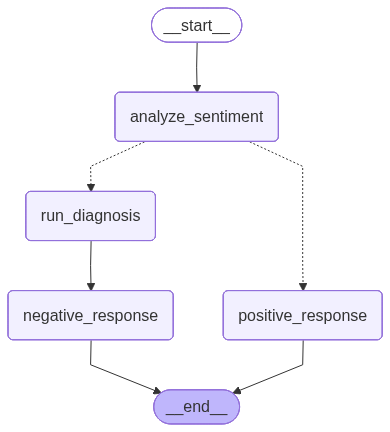

In [18]:
workflow

In [19]:
input_state = {
    "review": "I didn’t think I’d care much about the search filters, but now I use them constantly. Being able to narrow results by date, category, and even ‘recently viewed’ saves me way more time than I expected. The UI is mostly intuitive, though it took me a minute to realize you could swipe to see more filter options. Once you get the hang of it, it’s genuinely helpful. Would be five stars if it remembered my last-used filters automatically"
}
workflow.invoke(input_state)

{'review': 'I didn’t think I’d care much about the search filters, but now I use them constantly. Being able to narrow results by date, category, and even ‘recently viewed’ saves me way more time than I expected. The UI is mostly intuitive, though it took me a minute to realize you could swipe to see more filter options. Once you get the hang of it, it’s genuinely helpful. Would be five stars if it remembered my last-used filters automatically',
 'sentiment': 'positive',
 'response': 'Hi there!  \n\nThank you so much for taking the time to share your experience with our search filters. It’s fantastic to hear that they’re now a daily part of your workflow and that they’re saving you so much time. We’re glad the UI feels intuitive for the most part, and we appreciate the heads‑up about the swipe‑to‑see‑more feature—your feedback helps us make the experience smoother for everyone.  \n\nYour suggestion about automatically remembering the last‑used filters is spot on, and we’re already look